# UserBasicClassifier
Un classificador básico con la matadata del usuario

In [264]:
!pip install --upgrade pip
import pandas as pd
import numpy as np

import os
import pickle

from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model  import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

  Found existing installation: pip 19.0.3
    Uninstalling pip-19.0.3:
      Successfully uninstalled pip-19.0.3
  Rolling back uninstall of pip
  Moving to c:\users\matias\appdata\roaming\python\python36\scripts\pip.exe
   from C:\Users\matias\AppData\Local\Temp\pip-uninstall-q4_salpy\pip.exe
  Moving to c:\users\matias\appdata\roaming\python\python36\scripts\pip3.6.exe
   from C:\Users\matias\AppData\Local\Temp\pip-uninstall-q4_salpy\pip3.6.exe
  Moving to c:\users\matias\appdata\roaming\python\python36\scripts\pip3.exe
   from C:\Users\matias\AppData\Local\Temp\pip-uninstall-q4_salpy\pip3.exe
  Moving to c:\users\matias\appdata\roaming\python\python36\site-packages\pip-19.0.3.dist-info\
   from c:\users\matias\appdata\roaming\python\python36\site-packages\~ip-19.0.3.dist-info
  Moving to c:\users\matias\appdata\roaming\python\python36\site-packages\pip\
   from c:\users\matias\appdata\roaming\python\python36\site-packages\~ip


Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Program Files (x86)\\Microsoft Visual Studio\\Shared\\Anaconda3_64\\Lib\\site-packages\\pip\\__init__.py'
Consider using the `--user` option or check the permissions.

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [4]:
users = pd.read_pickle('trainDatasets/users_dataset.pkl')

In [5]:
users.head()

,id,screen_name,complete_name,description,verified,crawled_at,location,url,created_at,tweet_count,listed_count,favs_count,followers_count,following_count,bot,user_type
24858289,24858289,davideb66,Davide Bertoli,NaN,NaN,2014-04-19 14:46:19,NaN,NaN,Tue Mar 17 08:51:12 +0000 2009,1299,0,1,22,40,True,Spambot_1
33212890,33212890,ElisaDospina,Elisa D'Ospina,Autrice del libro #unavitatuttacurve dal 9 apr...,NaN,2014-05-18 23:20:58,Italy,http://t.co/ceK8TovxwI,Sun Apr 19 14:38:04 +0000 2009,18665,110,16358,12561,3442,True,Spambot_1
39773427,39773427,Vladimir65,Donato Vincenzo,[Live Long and Prosper],NaN,2014-05-13 23:21:54,"iPhone: 45.471680,9.192429",NaN,Wed May 13 15:34:41 +0000 2009,22987,6,14,600,755,True,Spambot_1
57007623,57007623,RafielaMorales,Rafiela Morales L.,"Cuasi Odontologa*♥,#Bipolar, #Sarcastica & Som...",NaN,2014-05-19 23:24:18,"ÜT: 18.4698712,-69.9327525",NaN,Wed Jul 15 12:55:03 +0000 2009,7975,2,11,398,350,True,Spambot_1
63258466,63258466,FabrizioC_c,§ h a † u r♄,"I shall rise from my own death, to avenge hers...",NaN,2014-05-11 23:22:23,Firenze,http://t.co/PK5F0JDKcy,Wed Aug 05 21:12:49 +0000 2009,20218,8,162,413,405,True,Spambot_1


In [279]:
def transform_x(df):
    df.loc[:, 'crawled_at'] = pd.DatetimeIndex(pd.to_datetime(df.crawled_at, utc=None)).tz_convert(tz='UTC')
    df.loc[:, 'created_at'] = pd.DatetimeIndex(pd.to_datetime(df.created_at, utc=None)).tz_convert(tz='UTC')
    account_life = df.crawled_at - df.created_at
    account_life_meses = np.round(account_life.dt.days / 30)
    account_life_meses = account_life_meses.replace(0, 1)
    account_life_semanas = np.round(account_life.dt.days / 7)
    account_life_semanas = account_life_semanas.replace(0, 1)
    numValues = ['tweet_count', 'listed_count', 'favs_count', 'followers_count', 'following_count']
    for i in numValues:
        colName_mes = i+'_mes'
        df.loc[:,colName_mes] = df[i] / account_life_meses

        colName_semana = i+'_semana'
        df.loc[:,colName_semana] = df[i] / account_life_semanas

    df.loc[:,'verified'] = ~df.verified.isna()
    df.loc[:,'description'] = ~df.description.isna()
    df.loc[:,'location'] = ~df.location.isna()
    df.loc[:,'url'] = ~df.url.isna()

    columnas = np.concatenate(
        [[x, x+'_mes', x+'_semana'] for x in numValues]
    )
    columnas = np.concatenate([
        [
            'verified',
            'description',
            'location',
            'url',
        ],
        columnas
    ])
    df = df[columnas]
    df = df.fillna(0)
    return df
    
#     def fit(self, x, y=0):
#         return self
#     def transform(self, x, y=0):
#         x = self.getVars(x)
#         return x
#     def fit_transform(self, x, y=0):
#         x = self.getVars(x)
#         return x

In [281]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('cat', CatBoostClassifier())
])

le = preprocessing.LabelEncoder()
x = transform_x(users)
y =  le.fit_transform(users['bot'])

X_train, X_test, y_train, y_test = train_test_split(x, y)

pipeline.fit(X_train, y_train)

Learning rate set to 0.028192
0:	learn: 0.6294076	total: 37.5ms	remaining: 37.5s
1:	learn: 0.5755444	total: 76.5ms	remaining: 38.2s
2:	learn: 0.5286895	total: 117ms	remaining: 38.8s
3:	learn: 0.4856825	total: 150ms	remaining: 37.4s
4:	learn: 0.4415766	total: 183ms	remaining: 36.4s
5:	learn: 0.4022022	total: 222ms	remaining: 36.8s
6:	learn: 0.3725155	total: 255ms	remaining: 36.2s
7:	learn: 0.3465487	total: 291ms	remaining: 36.1s
8:	learn: 0.3219165	total: 326ms	remaining: 35.9s
9:	learn: 0.2990574	total: 360ms	remaining: 35.6s
10:	learn: 0.2774287	total: 397ms	remaining: 35.7s
11:	learn: 0.2582766	total: 429ms	remaining: 35.4s
12:	learn: 0.2406139	total: 462ms	remaining: 35.1s
13:	learn: 0.2239664	total: 494ms	remaining: 34.8s
14:	learn: 0.2085539	total: 528ms	remaining: 34.7s
15:	learn: 0.1962521	total: 561ms	remaining: 34.5s
16:	learn: 0.1847320	total: 598ms	remaining: 34.6s
17:	learn: 0.1737223	total: 631ms	remaining: 34.4s
18:	learn: 0.1642739	total: 663ms	remaining: 34.2s
19:	learn

164:	learn: 0.0402201	total: 5.75s	remaining: 29.1s
165:	learn: 0.0401206	total: 5.79s	remaining: 29.1s
166:	learn: 0.0400920	total: 5.82s	remaining: 29s
167:	learn: 0.0399728	total: 5.85s	remaining: 29s
168:	learn: 0.0398999	total: 5.89s	remaining: 28.9s
169:	learn: 0.0397999	total: 5.92s	remaining: 28.9s
170:	learn: 0.0397481	total: 5.95s	remaining: 28.9s
171:	learn: 0.0396811	total: 5.99s	remaining: 28.8s
172:	learn: 0.0395951	total: 6.03s	remaining: 28.8s
173:	learn: 0.0395396	total: 6.06s	remaining: 28.8s
174:	learn: 0.0394817	total: 6.1s	remaining: 28.7s
175:	learn: 0.0393657	total: 6.13s	remaining: 28.7s
176:	learn: 0.0393537	total: 6.17s	remaining: 28.7s
177:	learn: 0.0393199	total: 6.2s	remaining: 28.6s
178:	learn: 0.0392708	total: 6.23s	remaining: 28.6s
179:	learn: 0.0392061	total: 6.26s	remaining: 28.5s
180:	learn: 0.0391674	total: 6.29s	remaining: 28.5s
181:	learn: 0.0391261	total: 6.33s	remaining: 28.4s
182:	learn: 0.0390782	total: 6.36s	remaining: 28.4s
183:	learn: 0.0390

327:	learn: 0.0332677	total: 11.3s	remaining: 23.1s
328:	learn: 0.0332006	total: 11.3s	remaining: 23.1s
329:	learn: 0.0331649	total: 11.3s	remaining: 23s
330:	learn: 0.0331199	total: 11.4s	remaining: 23s
331:	learn: 0.0331113	total: 11.4s	remaining: 22.9s
332:	learn: 0.0330159	total: 11.4s	remaining: 22.9s
333:	learn: 0.0329956	total: 11.5s	remaining: 22.9s
334:	learn: 0.0329827	total: 11.5s	remaining: 22.8s
335:	learn: 0.0329535	total: 11.5s	remaining: 22.8s
336:	learn: 0.0329348	total: 11.6s	remaining: 22.8s
337:	learn: 0.0328950	total: 11.6s	remaining: 22.7s
338:	learn: 0.0328866	total: 11.6s	remaining: 22.7s
339:	learn: 0.0328716	total: 11.7s	remaining: 22.7s
340:	learn: 0.0328410	total: 11.7s	remaining: 22.6s
341:	learn: 0.0327981	total: 11.8s	remaining: 22.6s
342:	learn: 0.0327826	total: 11.8s	remaining: 22.6s
343:	learn: 0.0327725	total: 11.8s	remaining: 22.5s
344:	learn: 0.0327718	total: 11.8s	remaining: 22.5s
345:	learn: 0.0327637	total: 11.9s	remaining: 22.4s
346:	learn: 0.03

487:	learn: 0.0292925	total: 16.5s	remaining: 17.3s
488:	learn: 0.0292884	total: 16.5s	remaining: 17.3s
489:	learn: 0.0292445	total: 16.6s	remaining: 17.3s
490:	learn: 0.0292274	total: 16.6s	remaining: 17.2s
491:	learn: 0.0291765	total: 16.6s	remaining: 17.2s
492:	learn: 0.0291656	total: 16.7s	remaining: 17.2s
493:	learn: 0.0291586	total: 16.7s	remaining: 17.1s
494:	learn: 0.0291314	total: 16.8s	remaining: 17.1s
495:	learn: 0.0291256	total: 16.8s	remaining: 17.1s
496:	learn: 0.0291019	total: 16.8s	remaining: 17s
497:	learn: 0.0290510	total: 16.9s	remaining: 17s
498:	learn: 0.0290427	total: 16.9s	remaining: 17s
499:	learn: 0.0290085	total: 17s	remaining: 17s
500:	learn: 0.0289948	total: 17s	remaining: 16.9s
501:	learn: 0.0289600	total: 17s	remaining: 16.9s
502:	learn: 0.0289204	total: 17.1s	remaining: 16.9s
503:	learn: 0.0289122	total: 17.1s	remaining: 16.8s
504:	learn: 0.0289074	total: 17.1s	remaining: 16.8s
505:	learn: 0.0289048	total: 17.2s	remaining: 16.8s
506:	learn: 0.0289000	tota

646:	learn: 0.0263948	total: 22.8s	remaining: 12.4s
647:	learn: 0.0263900	total: 22.8s	remaining: 12.4s
648:	learn: 0.0263893	total: 22.9s	remaining: 12.4s
649:	learn: 0.0263884	total: 22.9s	remaining: 12.3s
650:	learn: 0.0263883	total: 22.9s	remaining: 12.3s
651:	learn: 0.0263834	total: 23s	remaining: 12.3s
652:	learn: 0.0263766	total: 23s	remaining: 12.2s
653:	learn: 0.0263764	total: 23s	remaining: 12.2s
654:	learn: 0.0263428	total: 23.1s	remaining: 12.1s
655:	learn: 0.0263424	total: 23.1s	remaining: 12.1s
656:	learn: 0.0263424	total: 23.1s	remaining: 12.1s
657:	learn: 0.0263399	total: 23.1s	remaining: 12s
658:	learn: 0.0263398	total: 23.2s	remaining: 12s
659:	learn: 0.0263157	total: 23.2s	remaining: 11.9s
660:	learn: 0.0263109	total: 23.2s	remaining: 11.9s
661:	learn: 0.0262871	total: 23.3s	remaining: 11.9s
662:	learn: 0.0262821	total: 23.3s	remaining: 11.8s
663:	learn: 0.0262802	total: 23.3s	remaining: 11.8s
664:	learn: 0.0262633	total: 23.4s	remaining: 11.8s
665:	learn: 0.0262217	

809:	learn: 0.0247304	total: 29s	remaining: 6.8s
810:	learn: 0.0247294	total: 29.1s	remaining: 6.77s
811:	learn: 0.0247290	total: 29.1s	remaining: 6.73s
812:	learn: 0.0247289	total: 29.1s	remaining: 6.7s
813:	learn: 0.0247277	total: 29.1s	remaining: 6.66s
814:	learn: 0.0247020	total: 29.2s	remaining: 6.62s
815:	learn: 0.0247015	total: 29.2s	remaining: 6.58s
816:	learn: 0.0246896	total: 29.2s	remaining: 6.55s
817:	learn: 0.0246736	total: 29.3s	remaining: 6.51s
818:	learn: 0.0246477	total: 29.3s	remaining: 6.48s
819:	learn: 0.0246390	total: 29.3s	remaining: 6.44s
820:	learn: 0.0246383	total: 29.4s	remaining: 6.4s
821:	learn: 0.0246378	total: 29.4s	remaining: 6.37s
822:	learn: 0.0246359	total: 29.4s	remaining: 6.33s
823:	learn: 0.0246348	total: 29.5s	remaining: 6.3s
824:	learn: 0.0246347	total: 29.5s	remaining: 6.26s
825:	learn: 0.0246314	total: 29.5s	remaining: 6.22s
826:	learn: 0.0246300	total: 29.6s	remaining: 6.19s
827:	learn: 0.0246235	total: 29.6s	remaining: 6.15s
828:	learn: 0.0246

972:	learn: 0.0231162	total: 34.5s	remaining: 957ms
973:	learn: 0.0231159	total: 34.5s	remaining: 921ms
974:	learn: 0.0230308	total: 34.5s	remaining: 886ms
975:	learn: 0.0230299	total: 34.6s	remaining: 850ms
976:	learn: 0.0230265	total: 34.6s	remaining: 815ms
977:	learn: 0.0230013	total: 34.6s	remaining: 779ms
978:	learn: 0.0229967	total: 34.7s	remaining: 744ms
979:	learn: 0.0229937	total: 34.7s	remaining: 708ms
980:	learn: 0.0229845	total: 34.7s	remaining: 673ms
981:	learn: 0.0229817	total: 34.8s	remaining: 637ms
982:	learn: 0.0229481	total: 34.8s	remaining: 602ms
983:	learn: 0.0229361	total: 34.8s	remaining: 566ms
984:	learn: 0.0229044	total: 34.9s	remaining: 531ms
985:	learn: 0.0228673	total: 34.9s	remaining: 496ms
986:	learn: 0.0228654	total: 34.9s	remaining: 460ms
987:	learn: 0.0228465	total: 35s	remaining: 425ms
988:	learn: 0.0228144	total: 35s	remaining: 389ms
989:	learn: 0.0228055	total: 35.1s	remaining: 354ms
990:	learn: 0.0228052	total: 35.1s	remaining: 319ms
991:	learn: 0.02

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('cat', <catboost.core.CatBoostClassifier object at 0x0000023E8005A6A0>)])

El valor del AUC es:  0.9980325795130798


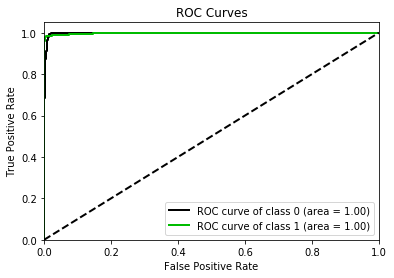

In [282]:
y_predicted_cat = pipeline.predict_proba(X_test)
y_pred = pipeline.predict(X_test)

from sklearn.metrics import roc_auc_score
cat_auc = roc_auc_score(y_test,y_predicted_cat[:,1])
print("El valor del AUC es: ", cat_auc)
from scikitplot.metrics import plot_roc
%matplotlib inline
plot_roc(y_test,y_predicted_cat, plot_micro = False, plot_macro= False)

In [284]:
# Matriz de Confusión
conf = confusion_matrix(y_test, y_pred)
predicted_cols = ['pred_'+str(c) for c in le.classes_]
display(pd.DataFrame(conf, index= ['real_Human','real_Bot'],columns = ['pred_Human','pred_Bot']))
print(classification_report(y_test, y_pred))

,pred_Human,pred_Bot
real_Human,865,18
real_Bot,17,1197


             precision    recall  f1-score   support

          0       0.98      0.98      0.98       883
          1       0.99      0.99      0.99      1214

avg / total       0.98      0.98      0.98      2097



In [285]:
# Re-Entrenar con el dataset completo
modelo = pipeline.fit(transform_x(users), y)

Learning rate set to 0.030584
0:	learn: 0.6348628	total: 45.7ms	remaining: 45.7s
1:	learn: 0.5733445	total: 88.5ms	remaining: 44.2s
2:	learn: 0.5064493	total: 134ms	remaining: 44.4s
3:	learn: 0.4642480	total: 171ms	remaining: 42.7s
4:	learn: 0.4203130	total: 211ms	remaining: 42s
5:	learn: 0.3868924	total: 248ms	remaining: 41.1s
6:	learn: 0.3568709	total: 285ms	remaining: 40.4s
7:	learn: 0.3268826	total: 321ms	remaining: 39.8s
8:	learn: 0.2997187	total: 357ms	remaining: 39.3s
9:	learn: 0.2782672	total: 398ms	remaining: 39.4s
10:	learn: 0.2583182	total: 434ms	remaining: 39s
11:	learn: 0.2392998	total: 470ms	remaining: 38.7s
12:	learn: 0.2220446	total: 505ms	remaining: 38.4s
13:	learn: 0.2066830	total: 541ms	remaining: 38.1s
14:	learn: 0.1946488	total: 581ms	remaining: 38.2s
15:	learn: 0.1816697	total: 617ms	remaining: 37.9s
16:	learn: 0.1713181	total: 652ms	remaining: 37.7s
17:	learn: 0.1617456	total: 689ms	remaining: 37.6s
18:	learn: 0.1537467	total: 725ms	remaining: 37.4s
19:	learn: 0.

160:	learn: 0.0410674	total: 6.11s	remaining: 31.9s
161:	learn: 0.0410090	total: 6.15s	remaining: 31.8s
162:	learn: 0.0409905	total: 6.19s	remaining: 31.8s
163:	learn: 0.0409195	total: 6.22s	remaining: 31.7s
164:	learn: 0.0408729	total: 6.26s	remaining: 31.7s
165:	learn: 0.0408587	total: 6.3s	remaining: 31.6s
166:	learn: 0.0407733	total: 6.33s	remaining: 31.6s
167:	learn: 0.0406836	total: 6.37s	remaining: 31.6s
168:	learn: 0.0405986	total: 6.41s	remaining: 31.5s
169:	learn: 0.0404874	total: 6.45s	remaining: 31.5s
170:	learn: 0.0404628	total: 6.49s	remaining: 31.4s
171:	learn: 0.0403488	total: 6.52s	remaining: 31.4s
172:	learn: 0.0403177	total: 6.56s	remaining: 31.4s
173:	learn: 0.0402767	total: 6.59s	remaining: 31.3s
174:	learn: 0.0402057	total: 6.63s	remaining: 31.3s
175:	learn: 0.0401903	total: 6.67s	remaining: 31.2s
176:	learn: 0.0400718	total: 6.71s	remaining: 31.2s
177:	learn: 0.0400151	total: 6.75s	remaining: 31.1s
178:	learn: 0.0399403	total: 6.78s	remaining: 31.1s
179:	learn: 0

320:	learn: 0.0345780	total: 12s	remaining: 25.5s
321:	learn: 0.0345576	total: 12.1s	remaining: 25.4s
322:	learn: 0.0345400	total: 12.1s	remaining: 25.4s
323:	learn: 0.0344862	total: 12.2s	remaining: 25.4s
324:	learn: 0.0344793	total: 12.2s	remaining: 25.4s
325:	learn: 0.0344090	total: 12.3s	remaining: 25.4s
326:	learn: 0.0343998	total: 12.3s	remaining: 25.3s
327:	learn: 0.0343772	total: 12.3s	remaining: 25.3s
328:	learn: 0.0343725	total: 12.4s	remaining: 25.2s
329:	learn: 0.0343343	total: 12.4s	remaining: 25.2s
330:	learn: 0.0343024	total: 12.5s	remaining: 25.2s
331:	learn: 0.0343010	total: 12.5s	remaining: 25.1s
332:	learn: 0.0342809	total: 12.5s	remaining: 25.1s
333:	learn: 0.0342775	total: 12.6s	remaining: 25.1s
334:	learn: 0.0342340	total: 12.6s	remaining: 25s
335:	learn: 0.0342223	total: 12.7s	remaining: 25s
336:	learn: 0.0341983	total: 12.7s	remaining: 25s
337:	learn: 0.0341900	total: 12.8s	remaining: 25s
338:	learn: 0.0341510	total: 12.8s	remaining: 25s
339:	learn: 0.0341499	to

483:	learn: 0.0301767	total: 18.1s	remaining: 19.3s
484:	learn: 0.0301682	total: 18.2s	remaining: 19.3s
485:	learn: 0.0301667	total: 18.2s	remaining: 19.3s
486:	learn: 0.0301658	total: 18.2s	remaining: 19.2s
487:	learn: 0.0301417	total: 18.3s	remaining: 19.2s
488:	learn: 0.0301221	total: 18.3s	remaining: 19.1s
489:	learn: 0.0300980	total: 18.3s	remaining: 19.1s
490:	learn: 0.0300779	total: 18.4s	remaining: 19.1s
491:	learn: 0.0300596	total: 18.4s	remaining: 19s
492:	learn: 0.0299958	total: 18.5s	remaining: 19s
493:	learn: 0.0299707	total: 18.5s	remaining: 18.9s
494:	learn: 0.0299581	total: 18.5s	remaining: 18.9s
495:	learn: 0.0299505	total: 18.6s	remaining: 18.9s
496:	learn: 0.0299207	total: 18.6s	remaining: 18.8s
497:	learn: 0.0298924	total: 18.6s	remaining: 18.8s
498:	learn: 0.0298726	total: 18.7s	remaining: 18.8s
499:	learn: 0.0298442	total: 18.7s	remaining: 18.7s
500:	learn: 0.0298421	total: 18.7s	remaining: 18.7s
501:	learn: 0.0298354	total: 18.8s	remaining: 18.6s
502:	learn: 0.02

645:	learn: 0.0268423	total: 24.2s	remaining: 13.2s
646:	learn: 0.0268419	total: 24.2s	remaining: 13.2s
647:	learn: 0.0268345	total: 24.2s	remaining: 13.2s
648:	learn: 0.0268293	total: 24.3s	remaining: 13.1s
649:	learn: 0.0268286	total: 24.3s	remaining: 13.1s
650:	learn: 0.0268089	total: 24.3s	remaining: 13s
651:	learn: 0.0267930	total: 24.4s	remaining: 13s
652:	learn: 0.0267856	total: 24.4s	remaining: 13s
653:	learn: 0.0267822	total: 24.4s	remaining: 12.9s
654:	learn: 0.0267667	total: 24.5s	remaining: 12.9s
655:	learn: 0.0267571	total: 24.5s	remaining: 12.9s
656:	learn: 0.0267547	total: 24.6s	remaining: 12.8s
657:	learn: 0.0267478	total: 24.6s	remaining: 12.8s
658:	learn: 0.0267442	total: 24.6s	remaining: 12.8s
659:	learn: 0.0267123	total: 24.7s	remaining: 12.7s
660:	learn: 0.0267105	total: 24.7s	remaining: 12.7s
661:	learn: 0.0267051	total: 24.8s	remaining: 12.6s
662:	learn: 0.0267015	total: 24.8s	remaining: 12.6s
663:	learn: 0.0266979	total: 24.9s	remaining: 12.6s
664:	learn: 0.0266

808:	learn: 0.0246873	total: 30.2s	remaining: 7.14s
809:	learn: 0.0246871	total: 30.3s	remaining: 7.1s
810:	learn: 0.0246762	total: 30.3s	remaining: 7.06s
811:	learn: 0.0246178	total: 30.3s	remaining: 7.02s
812:	learn: 0.0246162	total: 30.4s	remaining: 6.98s
813:	learn: 0.0246139	total: 30.4s	remaining: 6.95s
814:	learn: 0.0245890	total: 30.4s	remaining: 6.91s
815:	learn: 0.0245880	total: 30.5s	remaining: 6.87s
816:	learn: 0.0245379	total: 30.5s	remaining: 6.83s
817:	learn: 0.0245353	total: 30.6s	remaining: 6.8s
818:	learn: 0.0245129	total: 30.6s	remaining: 6.76s
819:	learn: 0.0244888	total: 30.6s	remaining: 6.73s
820:	learn: 0.0244880	total: 30.7s	remaining: 6.69s
821:	learn: 0.0244874	total: 30.7s	remaining: 6.65s
822:	learn: 0.0244487	total: 30.7s	remaining: 6.61s
823:	learn: 0.0244466	total: 30.8s	remaining: 6.57s
824:	learn: 0.0244428	total: 30.8s	remaining: 6.54s
825:	learn: 0.0244368	total: 30.9s	remaining: 6.5s
826:	learn: 0.0244279	total: 30.9s	remaining: 6.46s
827:	learn: 0.0

968:	learn: 0.0231788	total: 36.1s	remaining: 1.15s
969:	learn: 0.0231744	total: 36.1s	remaining: 1.12s
970:	learn: 0.0231720	total: 36.2s	remaining: 1.08s
971:	learn: 0.0231634	total: 36.2s	remaining: 1.04s
972:	learn: 0.0231611	total: 36.2s	remaining: 1s
973:	learn: 0.0231604	total: 36.3s	remaining: 968ms
974:	learn: 0.0231528	total: 36.3s	remaining: 931ms
975:	learn: 0.0231509	total: 36.4s	remaining: 894ms
976:	learn: 0.0231224	total: 36.4s	remaining: 857ms
977:	learn: 0.0231198	total: 36.4s	remaining: 819ms
978:	learn: 0.0231180	total: 36.5s	remaining: 782ms
979:	learn: 0.0231144	total: 36.5s	remaining: 745ms
980:	learn: 0.0231140	total: 36.5s	remaining: 708ms
981:	learn: 0.0230993	total: 36.6s	remaining: 670ms
982:	learn: 0.0230981	total: 36.6s	remaining: 633ms
983:	learn: 0.0230952	total: 36.6s	remaining: 596ms
984:	learn: 0.0230750	total: 36.7s	remaining: 559ms
985:	learn: 0.0230582	total: 36.7s	remaining: 521ms
986:	learn: 0.0230419	total: 36.8s	remaining: 484ms
987:	learn: 0.0

In [286]:
# Exportar Modelo a archivo binario
filename = 'modelPipeline.pkl'
with open(filename, 'wb') as twModel:
    pickle.dump(modelo, twModel)